In [24]:
# !pip install category_encoders
# !pip install torch

In [25]:
import pandas as pd
import numpy as np
from category_encoders.ordinal import OrdinalEncoder
from sklearn.model_selection import train_test_split
from preprocess import DataPreprocessor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
import wandb
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [26]:
class MLP(nn.Module):
  def __init__(self):
    super(MLP, self).__init__()
    self.fc1 = nn.Linear(24, 64)
    self.fc2 = nn.Linear(64, 32)
    self.fc3 = nn.Linear(32, 1)
    # self.fc4 = nn.Linear(112, 56)
    # self.fc5 = nn.Linear(56, 1)
    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()
    self.dropout = nn.Dropout(0.25)

  def forward(self, x):
    x = self.fc1(x)
    x = self.relu(x)
    x = self.dropout(x)
    x = self.fc2(x)
    x = self.relu(x)
    x = self.dropout(x)
    x = self.fc3(x)
    # x = self.relu(x)
    # x = self.dropout(x)
    # x = self.fc4(x)
    # x = self.relu(x)
    # x = self.dropout(x)
    # x = self.fc5(x)
    x = self.sigmoid(x)
    return x

def calculate_accuracy(outputs, targets):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == targets).sum().item()
    accuracy = correct / targets.size(0)
    return accuracy

In [27]:
wandb.login()
wandb.init(project="mlp")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [28]:
with open(os.path.join('config', 'config.json')) as f:
    preprocess_columns = json.load(f)

In [29]:
# 데이터 읽기
df_train = pd.read_csv("train.csv")  # 학습용 데이터
df_test = pd.read_csv("submission.csv")  # 테스트 데이터(제출파일의 데이터)
df_test = df_test.drop(columns=['id'], axis=1)

In [30]:
df_test

,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,id_strategic_ver,it_strategic_ver,...,response_corporate,expected_timeline,ver_cus,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,business_area,business_subarea,lead_owner,is_converted
0,0.00,/ / Brazil,ID,0.073248,47466,End Customer,Enterprise,53.0,NaN,NaN,...,LGESP,NaN,1,0,0.001183,0.049840,retail,Electronics & Telco,278,False
1,0.25,400 N State Of Franklin Rd Cloud IT / Johnson...,IT,NaN,5405,End Customer,SMB,NaN,NaN,NaN,...,LGEUS,NaN,0,0,0.000013,NaN,transportation,Others,437,True
2,1.00,/ / U.A.E,ID,NaN,13597,Specifier/ Influencer,SMB,NaN,NaN,NaN,...,LGEGF,less than 3 months,0,0,0.000060,0.131148,hospital & health care,General Hospital,874,False
3,0.50,/ Madison / United States,ID,0.118644,17204,NaN,Enterprise,NaN,NaN,NaN,...,LGEUS,more than a year,0,0,0.001183,0.049840,retail,NaN,194,False
4,1.00,/ Sao Paulo / Brazil,ID,0.074949,2329,End Customer,Enterprise,2.0,1.0,NaN,...,LGESP,less than 3 months,1,1,0.003079,0.064566,corporate / office,Engineering,167,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5266,0.50,/São Paulo/Brazil,AS,NaN,40292,NaN,Enterprise,10.0,NaN,NaN,...,LGESP,NaN,0,0,NaN,NaN,NaN,NaN,97,False
5267,0.25,General / / United States,IT,NaN,47466,NaN,Enterprise,0.0,NaN,NaN,...,LGEUS,NaN,0,0,NaN,NaN,NaN,NaN,438,True
5268,0.75,/ OURO BRANCO / Brazil,AS,NaN,46227,Specifier/ Influencer,Enterprise,NaN,NaN,NaN,...,LGESP,less than 3 months,0,0,NaN,NaN,NaN,NaN,97,False
5269,0.00,/ / Germany,IT,NaN,45667,End Customer,SMB,NaN,NaN,NaN,...,LGEDG,NaN,0,0,NaN,NaN,NaN,NaN,429,False


In [31]:
# 데이터 전처리
preprocessor = DataPreprocessor(preprocess_columns)
df_train_processed = preprocessor.fit_transform(df_train)
df_test_processed = preprocessor.transform(df_test)

In [32]:
import numpy as np
def outlier_iqr(data, column): 

    # lower, upper 글로벌 변수 선언하기     
    global lower, upper    
    
    # 4분위수 기준 지정하기     
    q25, q75 = np.quantile(data[column], 0.25), np.quantile(data[column], 0.75)          
    
    # IQR 계산하기     
    iqr = q75 - q25    
    
    # outlier cutoff 계산하기     
    cut_off = iqr * 1.5          
    
    # lower와 upper bound 값 구하기     
    lower, upper = q25 - cut_off, q75 + cut_off     
    
    print('IQR은',iqr, '이다.')     
    print('lower bound 값은', lower, '이다.')     
    print('upper bound 값은', upper, '이다.')    
    
    # 1사 분위와 4사 분위에 속해있는 데이터 각각 저장하기     
    data1 = data[data[column] > upper]     
    data2 = data[data[column] < lower]    
    
    # 이상치 총 개수 구하기
    return print('총 이상치 개수는', data1.shape[0] + data2.shape[0], '이다.'), lower, upper

In [33]:
_, lower, upper = outlier_iqr(df_train_processed, 'customer_country')

IQR은 21.0 이다.
lower bound 값은 -29.5 이다.
upper bound 값은 54.5 이다.
총 이상치 개수는 5522 이다.


In [34]:
df_train_processed = df_train_processed[(df_train_processed['customer_country'] < upper) & (df_train_processed['customer_country'] > lower)]

In [35]:
df_train_processed

,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise_Enterprise,enterprise_SMB,historical_existing_cnt,idit_strategic_ver,...,customer_position,response_corporate,expected_timeline,ver_cus,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,business_area,lead_owner,is_converted
0,1.00,1,1,0.066667,1,1,1,0,0.0,0.0,...,1,1,1,1,0,0.003079,0.026846,1,0.007235,True
1,1.00,1,1,0.066667,2,1,1,0,12.0,0.0,...,2,1,1,1,0,0.003079,0.026846,1,0.000337,True
2,1.00,2,1,0.088889,3,1,1,0,144.0,0.0,...,3,2,1,1,0,0.003079,0.026846,1,0.000675,True
3,1.00,2,1,0.088889,4,1,1,0,0.0,0.0,...,2,2,1,1,0,0.003079,0.026846,1,0.000489,True
4,1.00,2,1,0.088889,5,2,1,0,0.0,0.0,...,3,2,1,0,0,0.003079,0.026846,1,0.001282,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59293,1.00,50,1,0.000000,35108,7,0,1,0.0,0.0,...,1,28,3,0,0,0.000026,0.028777,13,0.003592,False
59294,1.00,50,1,0.000000,35108,7,0,1,0.0,0.0,...,1,28,3,0,0,0.000026,0.028777,13,0.003592,False
59295,0.75,10,1,0.040000,35109,2,1,0,0.0,0.0,...,11,10,4,0,0,0.000026,0.028777,13,0.005127,False
59296,0.75,42,1,0.040000,35110,2,1,0,0.0,0.0,...,1,24,1,0,0,0.000026,0.028777,13,0.011636,False


In [36]:
# "is_converted" 열에 대해 True를 1로, False를 0으로 변환
df_train_processed["is_converted"] = df_train_processed["is_converted"].replace({True: 1, False: 0})
df_test_processed["is_converted"] = df_test_processed["is_converted"].replace({True: 1, False: 0})
df_train_processed

,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise_Enterprise,enterprise_SMB,historical_existing_cnt,idit_strategic_ver,...,customer_position,response_corporate,expected_timeline,ver_cus,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,business_area,lead_owner,is_converted
0,1.00,1,1,0.066667,1,1,1,0,0.0,0.0,...,1,1,1,1,0,0.003079,0.026846,1,0.007235,1
1,1.00,1,1,0.066667,2,1,1,0,12.0,0.0,...,2,1,1,1,0,0.003079,0.026846,1,0.000337,1
2,1.00,2,1,0.088889,3,1,1,0,144.0,0.0,...,3,2,1,1,0,0.003079,0.026846,1,0.000675,1
3,1.00,2,1,0.088889,4,1,1,0,0.0,0.0,...,2,2,1,1,0,0.003079,0.026846,1,0.000489,1
4,1.00,2,1,0.088889,5,2,1,0,0.0,0.0,...,3,2,1,0,0,0.003079,0.026846,1,0.001282,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59293,1.00,50,1,0.000000,35108,7,0,1,0.0,0.0,...,1,28,3,0,0,0.000026,0.028777,13,0.003592,0
59294,1.00,50,1,0.000000,35108,7,0,1,0.0,0.0,...,1,28,3,0,0,0.000026,0.028777,13,0.003592,0
59295,0.75,10,1,0.040000,35109,2,1,0,0.0,0.0,...,11,10,4,0,0,0.000026,0.028777,13,0.005127,0
59296,0.75,42,1,0.040000,35110,2,1,0,0.0,0.0,...,1,24,1,0,0,0.000026,0.028777,13,0.011636,0


In [37]:
# 각 column에 대해 -2 또는 -1이 있는지 확인하고 최댓값 + 1로 변경
for column in df_test_processed.columns:
    count_neg1 = (df_test_processed[column] == -1).sum()
    count_neg2 = (df_test_processed[column] == -2).sum()
    
    if count_neg1 > 0 or count_neg2 > 0:
        max_value = df_test_processed[column].max()
        df_test_processed[column] = df_test_processed[column].replace([-2, -1], max_value + 1)
        print(f"Column '{column}': Replaced {count_neg2} occurrences of -2 and {count_neg1} occurrences of -1 with {max_value + 1}")

Column 'customer_country': Replaced 0 occurrences of -2 and 811 occurrences of -1 with 364.0
Column 'customer_idx': Replaced 0 occurrences of -2 and 4073 occurrences of -1 with 35087.0
Column 'customer_job': Replaced 0 occurrences of -2 and 2 occurrences of -1 with 111.0
Column 'product_category': Replaced 0 occurrences of -2 and 9 occurrences of -1 with 184.0
Column 'product_modelname': Replaced 0 occurrences of -2 and 47 occurrences of -1 with 652.0


In [39]:
numeric_col = ["historical_existing_cnt", "lead_desc_length", "customer_idx", "customer_country", 
        "business_unit",
        "customer_type",
        "customer_job",
        "inquiry_type",
        "product_category",
        "customer_position",
        "response_corporate",
        "expected_timeline",
        "business_area",
        "product_modelname" ]
scaler = MinMaxScaler()
train_len = len(df_train_processed)
df_all = pd.concat([df_train_processed, df_test_processed])
df_all[numeric_col] = scaler.fit_transform(df_all[numeric_col])
df_train_processed = df_all[:train_len]
df_test_processed = df_all[train_len:]

In [14]:
# # 수치형 데이터 스케일링
# numeric_col = ["historical_existing_cnt", "lead_desc_length", "customer_idx", "customer_country"] 
# scaler = MinMaxScaler()
# df_train_processed[numeric_col] = scaler.fit_transform(df_train_processed[numeric_col])
# df_test_processed[numeric_col] = scaler.transform(df_test_processed[numeric_col])


In [40]:
df_train_processed

,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise_Enterprise,enterprise_SMB,historical_existing_cnt,idit_strategic_ver,...,customer_position,response_corporate,expected_timeline,ver_cus,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,business_area,lead_owner,is_converted
0,1.00,0.000000,0.0,0.066667,0.000000,0.00,1,0,0.000000,0.0,...,0.000000,0.00,0.000000,1,0,0.003079,0.026846,0.0,0.007235,1
1,1.00,0.000000,0.0,0.066667,0.000028,0.00,1,0,0.005408,0.0,...,0.016667,0.00,0.000000,1,0,0.003079,0.026846,0.0,0.000337,1
2,1.00,0.002755,0.0,0.088889,0.000057,0.00,1,0,0.064894,0.0,...,0.033333,0.02,0.000000,1,0,0.003079,0.026846,0.0,0.000675,1
3,1.00,0.002755,0.0,0.088889,0.000085,0.00,1,0,0.000000,0.0,...,0.016667,0.02,0.000000,1,0,0.003079,0.026846,0.0,0.000489,1
4,1.00,0.002755,0.0,0.088889,0.000114,0.04,1,0,0.000000,0.0,...,0.033333,0.02,0.000000,0,0,0.003079,0.026846,0.0,0.001282,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59293,1.00,0.134986,0.0,0.000000,0.999915,0.24,0,1,0.000000,0.0,...,0.000000,0.54,0.036364,0,0,0.000026,0.028777,1.0,0.003592,0
59294,1.00,0.134986,0.0,0.000000,0.999915,0.24,0,1,0.000000,0.0,...,0.000000,0.54,0.036364,0,0,0.000026,0.028777,1.0,0.003592,0
59295,0.75,0.024793,0.0,0.040000,0.999943,0.04,1,0,0.000000,0.0,...,0.166667,0.18,0.054545,0,0,0.000026,0.028777,1.0,0.005127,0
59296,0.75,0.112948,0.0,0.040000,0.999972,0.04,1,0,0.000000,0.0,...,0.000000,0.46,0.000000,0,0,0.000026,0.028777,1.0,0.011636,0


In [41]:
df_test_processed

,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise_Enterprise,enterprise_SMB,historical_existing_cnt,idit_strategic_ver,...,customer_position,response_corporate,expected_timeline,ver_cus,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,business_area,lead_owner,is_converted
0,0.00,0.487603,0.25,0.073248,0.001424,0.24,1,0,0.023885,0.0,...,0.116667,0.10,0.018182,1,0,0.001183,0.049840,0.666667,0.001568,0
1,0.25,0.278237,0.50,0.000000,0.370806,0.24,0,1,0.000000,0.0,...,0.116667,0.16,0.018182,0,0,0.000013,0.000000,0.916667,0.002378,1
2,1.00,0.490358,0.25,0.000000,0.999316,0.04,0,1,0.000000,0.0,...,0.050000,0.12,0.000000,0,0,0.000060,0.131148,0.333333,0.000000,0
3,0.50,0.278237,0.25,0.118644,0.999316,0.16,1,0,0.000000,0.0,...,0.116667,0.16,0.072727,0,0,0.001183,0.049840,0.666667,0.037235,0
4,1.00,0.487603,0.25,0.074949,0.999316,0.24,1,0,0.000901,1.0,...,0.116667,0.10,0.000000,1,1,0.003079,0.064566,0.000000,0.007740,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5266,0.50,0.013774,0.00,0.000000,0.259869,0.16,1,0,0.004507,0.0,...,0.083333,0.10,0.018182,0,0,0.000000,0.000000,0.083333,0.042142,0
5267,0.25,0.278237,0.50,0.000000,0.001424,0.16,1,0,0.000000,0.0,...,0.116667,0.16,0.018182,0,0,0.000000,0.000000,0.083333,0.000472,1
5268,0.75,0.487603,0.00,0.000000,0.999316,0.04,1,0,0.000000,0.0,...,0.050000,0.10,0.000000,0,0,0.000000,0.000000,0.083333,0.042142,0
5269,0.00,0.506887,0.50,0.000000,0.999316,0.24,0,1,0.000000,0.0,...,0.116667,0.48,0.018182,0,0,0.000000,0.000000,0.083333,0.000236,0


In [42]:

x_train, x_val, y_train, y_val = train_test_split(
    df_train_processed.drop("is_converted", axis=1),
    df_train_processed["is_converted"],
    test_size=0.2,
    shuffle=True,
    random_state=400,
)

x_train_tensor = torch.tensor(x_train.values, dtype=torch.float32)
x_val_tensor = torch.tensor(x_val.values, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)

df_test_processed = df_test_processed.drop("is_converted", axis=1)
x_test_tensor = torch.tensor(df_test_processed.values, dtype=torch.float32)


In [43]:
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

valid_dataset = TensorDataset(x_val_tensor, y_val_tensor)
valid_dataloader = DataLoader(valid_dataset, batch_size=32)

In [44]:
model = MLP()

criterion = nn.BCELoss()

optimizer = optim.Adam(model.parameters(), lr=0.0001)
# 학습
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [46]:
num_epochs = 500
train_losses = []
valid_losses = []
for epoch in range(1, num_epochs+1):
    total_loss = 0.0
    total_accuracy = 0.0
    model.train()
    for batch_x, batch_y in train_dataloader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        outputs = model(batch_x)
        batch_y = batch_y.unsqueeze(1)
        loss = criterion(outputs, batch_y)
        total_loss += loss.item()

        accuracy = calculate_accuracy(outputs, batch_y)
        total_accuracy += accuracy

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_dataloader)
    avg_accuracy = total_accuracy / len(train_dataloader)
    train_losses.append(avg_loss)

    # Valid
    total_valid_loss = 0.0
    total_valid_accuracy = 0.0
    model.eval()
    with torch.no_grad() :
        for batch_x, batch_y in valid_dataloader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            
            outputs = model(batch_x)
            batch_y = batch_y.unsqueeze(1)
            valid_loss = criterion(outputs, batch_y)
            total_valid_loss += valid_loss.item()

            valid_accuracy = calculate_accuracy(outputs, batch_y)
            total_valid_accuracy += valid_accuracy
            
        avg_valid_loss = total_valid_loss / len(valid_dataloader)
        avg_valid_accuracy = total_valid_accuracy / len(valid_dataloader)
        valid_losses.append(avg_valid_loss)
    if epoch % 10 == 0:
        torch.save(model.state_dict(), f'{epoch}_epochs.pth')
        print('Epoch [{}/{}], Train Loss: {:.4f}, Train Accuracy: {:.4f}, Valid Loss: {:.4f}, Valid Accuracy: {:.4f}'.format(
            epoch, num_epochs, avg_loss, avg_accuracy, avg_valid_loss, avg_valid_accuracy))

Epoch [10/500], Train Loss: 0.1854, Train Accuracy: 29.3606, Valid Loss: 0.1797, Valid Accuracy: 29.1988
Epoch [20/500], Train Loss: 0.1747, Train Accuracy: 29.3606, Valid Loss: 0.1728, Valid Accuracy: 29.1988
Epoch [30/500], Train Loss: 0.1683, Train Accuracy: 29.3606, Valid Loss: 0.1662, Valid Accuracy: 29.1988
Epoch [40/500], Train Loss: 0.1635, Train Accuracy: 29.3606, Valid Loss: 0.1617, Valid Accuracy: 29.1988
Epoch [50/500], Train Loss: 0.1590, Train Accuracy: 29.3606, Valid Loss: 0.1581, Valid Accuracy: 29.1988
Epoch [60/500], Train Loss: 0.1549, Train Accuracy: 29.3606, Valid Loss: 0.1540, Valid Accuracy: 29.1988
Epoch [70/500], Train Loss: 0.1509, Train Accuracy: 29.3606, Valid Loss: 0.1503, Valid Accuracy: 29.1988
Epoch [80/500], Train Loss: 0.1487, Train Accuracy: 29.3606, Valid Loss: 0.1472, Valid Accuracy: 29.1988
Epoch [90/500], Train Loss: 0.1462, Train Accuracy: 29.3606, Valid Loss: 0.1438, Valid Accuracy: 29.1988
Epoch [100/500], Train Loss: 0.1436, Train Accuracy: 29

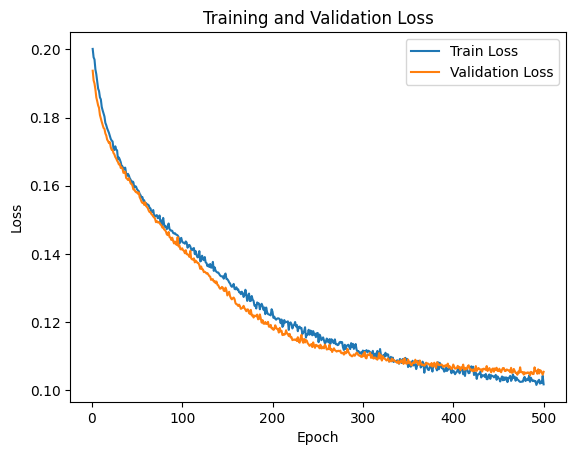

In [47]:
import matplotlib.pyplot as plt
# 그래프 그리기
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [72]:
# eval
model = MLP()  # 새로운 모델 인스턴스 생성
model.load_state_dict(torch.load('310_epochs.pth'))  
model.eval()

with torch.no_grad():
    x_test_tensor = x_test_tensor.to(device)
    print(x_test_tensor.shape)
    predictions = model(x_test_tensor)
    
predicted_labels = (predictions > 0.5).squeeze().tolist()
print(len(predicted_labels))
# 0과 1의 개수를 세기
count_zeros = predicted_labels.count(True)
count_ones = predicted_labels.count(False)
print("0의 개수:", count_zeros)
print("1의 개수:", count_ones)

torch.Size([5271, 24])
5271
0의 개수: 21
1의 개수: 5250


In [73]:
# NumPy 배열을 DataFrame으로 변환
df_predicted = pd.DataFrame(predicted_labels, columns=["is_converted"])

In [74]:
df_predicted

,is_converted
0,False
1,False
2,False
3,False
4,False
...,...
5266,False
5267,False
5268,False
5269,False


In [75]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["is_converted"] = df_predicted
# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

In [76]:
df_sub

,id,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,id_strategic_ver,...,response_corporate,expected_timeline,ver_cus,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,business_area,business_subarea,lead_owner,is_converted
0,19844,0.00,/ / Brazil,ID,0.073248,47466,End Customer,Enterprise,53.0,NaN,...,LGESP,NaN,1,0,0.001183,0.049840,retail,Electronics & Telco,278,False
1,9738,0.25,400 N State Of Franklin Rd Cloud IT / Johnson...,IT,NaN,5405,End Customer,SMB,NaN,NaN,...,LGEUS,NaN,0,0,0.000013,NaN,transportation,Others,437,False
2,8491,1.00,/ / U.A.E,ID,NaN,13597,Specifier/ Influencer,SMB,NaN,NaN,...,LGEGF,less than 3 months,0,0,0.000060,0.131148,hospital & health care,General Hospital,874,False
3,19895,0.50,/ Madison / United States,ID,0.118644,17204,NaN,Enterprise,NaN,NaN,...,LGEUS,more than a year,0,0,0.001183,0.049840,retail,NaN,194,False
4,10465,1.00,/ Sao Paulo / Brazil,ID,0.074949,2329,End Customer,Enterprise,2.0,1.0,...,LGESP,less than 3 months,1,1,0.003079,0.064566,corporate / office,Engineering,167,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5266,13855,0.50,/São Paulo/Brazil,AS,NaN,40292,NaN,Enterprise,10.0,NaN,...,LGESP,NaN,0,0,NaN,NaN,NaN,NaN,97,False
5267,7979,0.25,General / / United States,IT,NaN,47466,NaN,Enterprise,0.0,NaN,...,LGEUS,NaN,0,0,NaN,NaN,NaN,NaN,438,False
5268,12887,0.75,/ OURO BRANCO / Brazil,AS,NaN,46227,Specifier/ Influencer,Enterprise,NaN,NaN,...,LGESP,less than 3 months,0,0,NaN,NaN,NaN,NaN,97,False
5269,17530,0.00,/ / Germany,IT,NaN,45667,End Customer,SMB,NaN,NaN,...,LGEDG,NaN,0,0,NaN,NaN,NaN,NaN,429,False
